In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import product
from datetime import datetime
import json
from statannotations.Annotator import Annotator
from matplotlib.ticker import ScalarFormatter, NullFormatter

import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
from scipy import stats
import gym

import matplotlib.colors as mcolors
import matplotlib as mpl

from joblib import Parallel, delayed
import multiprocessing
import pickle

# create a color map using a list of hex values for the IBM colorblind safe palette
hex_list = ['#648fff','#785ef0','#dc267f','#fe6100','#ffb000']
cmap = mpl.colors.LinearSegmentedColormap.from_list('ibm_cbs', hex_list)

def rgba_to_hex(rgba):
    return mcolors.rgb2hex(rgba)

def change_lightness(color, amount=0.5):
    """ amount can be between -1 and 1 """
    import colorsys
    try:
        c = mcolors.to_rgb(color)
        c = colorsys.rgb_to_hls(*c)
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    except ValueError:
        return color

def pvalue_to_stars(pvalue):
    if pvalue < 0.0001:
        return '****'
    elif pvalue < 0.001:
        return '***'
    elif pvalue < 0.01:
        return '**'
    elif pvalue < 0.05:
        return '*'
    else:
        return 'ns'

# calculate the cliff's delta for two distributions
def cliffsDelta(x,y):
    """ Calculate the cliffs delta for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    prod = np.array(list(product(x,y)))
    diffs = np.int32(prod[:,0]<prod[:,1]) - np.int32(prod[:,0]>prod[:,1])
    return np.mean(diffs)

def pairedRankBiserialCorrelation(x,y):
    """ Calculate the paired rank biserial correlation for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    # calculate the signed rank
    signed_rank = np.sign(x-y)*stats.rankdata(np.abs(x-y))
    # get sum of positive and negative ranks
    pos_rank = np.sum(signed_rank[signed_rank>0])
    neg_rank = -np.sum(signed_rank[signed_rank<0])
    # calculate the proportion of positive and negative ranks
    pos_prop = pos_rank/(pos_rank+neg_rank)
    neg_prop = neg_rank/(pos_rank+neg_rank)
    # calculate the difference in proportion
    return pos_prop-neg_prop

def delta_to_effect(delta):
    """ Convert a cliffs delta to effect size """
    delta = np.abs(delta)
    if delta < 0.147:
        return 'neg'
    elif delta < 0.33:
        return '^'
    elif delta < 0.474:
        return '^^'
    elif delta > 0.474:
        return '^^^'
    else:
        return ''

def d_to_effect(d):
    """ Convert a Cohen's d to effect size """
    d = np.abs(d)
    if d < 0.2:
        return 'neg'
    elif d < 0.5:
        return '^'
    elif d < 0.8:
        return '^^'
    elif d > 0.8:
        return '^^^'
    else:
        return ''

def r_to_effect(r):
    """ Convert a rank biserial correlation to effect size according to Funder (2019)"""
    r = np.abs(r)
    if r < 0.1:
        return 'neg'
    elif r < 0.3:
        return '^'
    elif r < 0.4:
        return '^^'
    elif r > 0.4:
        return '^^^'
    else:
        return ''

def smoothen(x,width):
    if len(x.shape) == 1:
        # check if the first index is a number
        if isinstance(x[0],(int,float)):
            # add padding with 0.5 to avoid edge effects
            x = np.concatenate([np.ones(width-1)*0.5, x])
            # convolve with a boxcar
            x = np.convolve(x, np.ones(width)/width, mode='valid')
            return x
        else:
            xs = []
            for x_ in x:
                xs.append(smoothen(x_,width))
            return np.array(xs)
    elif len(x.shape) == 2:
        xs = []
        for i in range(x.shape[0]):
            xs.append(smoothen(x[i],width))
        return np.array(xs)
    elif len(x.shape) == 3:
        xs = []
        for i in range(x.shape[0]):
            xs.append(smoothen(x[i],width))
        return np.array(xs)
    else:
        raise ValueError("x must be 1, 2 or 3 dimensional")

In [29]:
# load data
training_choice_set = np.loadtxt('../../FlYMazeRL/data/mohanta2022/training_choice_set.csv',delimiter=',')
test_choice_set = np.loadtxt('../../FlYMazeRL/data/mohanta2022/test_choice_set.csv',delimiter=',')
training_reward_set = np.loadtxt('../../FlYMazeRL/data/mohanta2022/training_reward_set.csv',delimiter=',')
test_reward_set = np.loadtxt('../../FlYMazeRL/data/mohanta2022/test_reward_set.csv',delimiter=',')

## Phenomenological Model Analysis

In [30]:
def get_pickled_data(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def get_variable_from_dataset(dataset, variable):
    vars = [v[variable] for v in dataset]
    return vars

models = ["../../FlYMazeRL_Fits/regression/mohanta2022/"+model for model in os.listdir("../../FlYMazeRL_Fits/regression/mohanta2022/") if model.endswith("fit_results.pkl")] + \
            ["../../FlYMazeRL_Fits/matching/mohanta2022/" + model for model in os.listdir("../../FlYMazeRL_Fits/matching/mohanta2022/") if model.endswith("fit_results.pkl")]
# sort models by history length and order = [rci, ci, rc, ri, matching]
models.sort(key=lambda x: int(x.split('/')[-1].split("_")[2]))
models.sort(key=lambda x: sum([ord(v) for v in list(x.split('/')[-1].split("_")[1])]), reverse=True)
print(", ".join(model.split("/")[-1] for model in models))
# get data
dataset = [get_pickled_data(model) for model in tqdm(models)]

matching_law_5_fit_results.pkl, matching_law_10_fit_results.pkl, matching_law_15_fit_results.pkl, matching_law_30_fit_results.pkl, matching_law_60_fit_results.pkl, regression_rci_5_fit_results.pkl, regression_rci_10_fit_results.pkl, regression_rci_15_fit_results.pkl, regression_rci_30_fit_results.pkl, regression_rci_60_fit_results.pkl, regression_ri_5_fit_results.pkl, regression_ri_10_fit_results.pkl, regression_ri_15_fit_results.pkl, regression_ri_30_fit_results.pkl, regression_ri_60_fit_results.pkl, regression_rc_5_fit_results.pkl, regression_rc_10_fit_results.pkl, regression_rc_15_fit_results.pkl, regression_rc_30_fit_results.pkl, regression_rc_60_fit_results.pkl, regression_ci_5_fit_results.pkl, regression_ci_10_fit_results.pkl, regression_ci_15_fit_results.pkl, regression_ci_30_fit_results.pkl, regression_ci_60_fit_results.pkl


  0%|          | 0/25 [00:00<?, ?it/s]

In [49]:
# get model
test_nlls = get_variable_from_dataset(dataset, "test_nll")
training_nlls = get_variable_from_dataset(dataset, "training_nll")
test_preds = get_variable_from_dataset(dataset, "test_predictions")
training_preds = get_variable_from_dataset(dataset, "training_predictions")
params = get_variable_from_dataset(dataset, "params")

def get_means_and_se(data):
    means = np.array([np.mean(x) for x in data])
    se = np.array([np.std(x)/np.sqrt(x.shape[1]) for x in data])
    return means, se

def get_probs_and_ci(data,widths):
    probs = np.array([np.mean(smoothen(x,w), axis=0) for x,w in zip(data,widths)])
    cis = np.array([(np.quantile(smoothen(x,w),0.025,axis=0), np.quantile(smoothen(x,w),0.975,axis=0)) for x,w in zip(data,widths)])
    return probs, cis

In [68]:
# plot model performance for matching models
filtered_models = [model for model in models if "matching" in model]
filtered_names = ["{}({})".format(model.split("/")[-1].split("_")[0], model.split("/")[-1].split("_")[2]) for model in filtered_models]
filtered_widths =  [10]*len(filtered_models)
#[int(model.split("/")[-1].split("_")[2]) for model in filtered_models]
filtered_test_nlls = [test_nlls[i] for i in range(len(models)) if "matching" in models[i]]
filtered_training_nlls = [training_nlls[i] for i in range(len(models)) if "matching" in models[i]]
filtered_test_preds = [test_preds[i] for i in range(len(models)) if "matching" in models[i]]
filtered_training_preds = [training_preds[i] for i in range(len(models)) if "matching" in models[i]]
filtered_params = [params[i] for i in range(len(models)) if "matching" in models[i]]

filtered_test_means, filtered_test_se = get_means_and_se(filtered_test_nlls)
filtered_training_means, filtered_training_se = get_means_and_se(filtered_training_nlls)
filtered_test_probs, filtered_test_cis = get_probs_and_ci(filtered_test_preds, filtered_widths)
filtered_training_probs, filtered_training_cis = get_probs_and_ci(filtered_training_preds, filtered_widths)


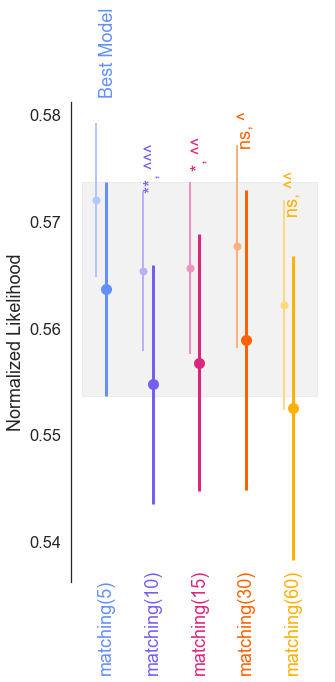

,Model,Test NL,Test SE,Training NL,Training SE,Test P-value,Test R,Training P-value,Training R
0,matching(5),0.563656,0.010040,0.571999,0.007173,NaN,NaN,NaN,NaN
1,matching(10),0.554716,0.011206,0.565320,0.007507,0.005106,0.484747,0.000751,0.413662
2,matching(15),0.556755,0.012079,0.565614,0.008096,0.037774,0.359596,0.005658,0.339632
3,matching(30),0.558863,0.014093,0.567647,0.009542,0.238522,0.204040,0.083504,0.212436
4,matching(60),0.552486,0.014226,0.562195,0.009848,0.061869,0.323232,0.007371,0.328907


In [69]:
best_model = np.argmax(filtered_test_means)
best_matching_model = filtered_models[best_model]
best_matching_name = filtered_names[best_model]
best_matching_test_nll = filtered_test_nlls[best_model]
best_matching_training_nll = filtered_training_nlls[best_model]
best_matching_test_preds = filtered_test_preds[best_model]
best_matching_training_preds = filtered_training_preds[best_model]
best_matching_width = filtered_widths[best_model]

# find statistically significant differences and effect sizes
pvals = []
rs = []
for i in range(len(filtered_models)):
    pvals_temp = []
    for j in range(filtered_test_nlls[i].shape[0]):
        try:
            pvals_temp.append(stats.wilcoxon(filtered_test_nlls[i][j], filtered_test_nlls[best_model][j])[1])
        except:
            pvals_temp.append(np.nan)
    pval = np.quantile(pvals_temp, 0.95)
    pvals.append(pval)
    rs_temp = []
    for j in range(filtered_test_nlls[i].shape[0]):
        
        rs_temp.append(pairedRankBiserialCorrelation(filtered_test_nlls[i][j], filtered_test_nlls[best_model][j]))
    r = np.quantile(np.abs(rs_temp), 0.05)
    rs.append(r)

pvals_training = []
rs_training = []
for i in range(len(filtered_models)):
    pvals_temp = []
    for j in range(filtered_training_nlls[i].shape[0]):
        try:
            pvals_temp.append(stats.wilcoxon(filtered_training_nlls[i][j], filtered_training_nlls[best_model][j])[1])
        except:
            pvals_temp.append(np.nan)
    pval = np.quantile(pvals_temp, 0.95)
    pvals_training.append(pval)
    rs_temp = []
    for j in range(filtered_training_nlls[i].shape[0]):
        
        rs_temp.append(pairedRankBiserialCorrelation(filtered_training_nlls[i][j], filtered_training_nlls[best_model][j]))
    r = np.quantile(np.abs(rs_temp), 0.05)
    rs_training.append(r)

sns.set(font_scale=1.5,style="white")
fig, ax = plt.subplots(figsize=(5,10))
for i in range(len(filtered_models)):
    ax.errorbar(i, filtered_test_means[i], yerr=filtered_test_se[i], color=change_lightness(cmap(i/(len(filtered_models)-1)), 1), elinewidth=3, markersize=10, fmt= 'o')
    ax.errorbar(i-0.2, filtered_training_means[i], yerr=filtered_training_se[i], color=change_lightness(cmap(i/(len(filtered_models)-1)), 0.5), elinewidth=2, markersize=7, fmt= 'o')
    ax.text(i, min(filtered_test_means)-0.025, filtered_names[i], ha='center', va='bottom', rotation=90, color=change_lightness(cmap(i/(len(filtered_models)-1)), 1))
    # add significance
    if i != best_model:
        ax.text(i, np.max(filtered_test_means[i])+0.018, f"{pvalue_to_stars(pvals[i])}, {r_to_effect(rs[i])}", ha='center', va='bottom', rotation=90, color=change_lightness(cmap(i/(len(filtered_models)-1)), 1))
    else:
        ax.text(i+0.05, np.max(filtered_test_means[i])+0.018, f"Best Model", ha='center', va='bottom', rotation=90, color=change_lightness(cmap(i/(len(filtered_models)-1)), 1))
# draw reference region
ax.fill_between([-0.5, len(filtered_models)-0.5], filtered_test_means[best_model]-filtered_test_se[best_model], filtered_test_means[best_model]+filtered_test_se[best_model], color='gray', alpha=0.1)
ax.set_xticks([])
ax.set_ylabel("Normalized Likelihood")
# turn off all spines except left
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig("figures/Matching_Models_summary.pdf", bbox_inches='tight')
plt.show()

statistics = pd.DataFrame({"Model": filtered_names, "Test NL" : filtered_test_means, "Test SE" : filtered_test_se, "Training NL" : filtered_training_means, "Training SE" : filtered_training_se, "Test P-value" : pvals, "Test R" : rs, "Training P-value" : pvals_training, "Training R" : rs_training})
statistics.to_csv("tables/Matching_Models_statistics.csv")
statistics

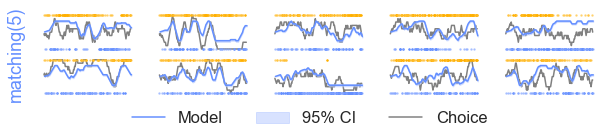

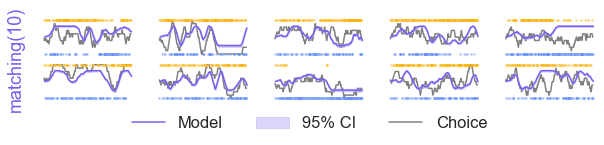

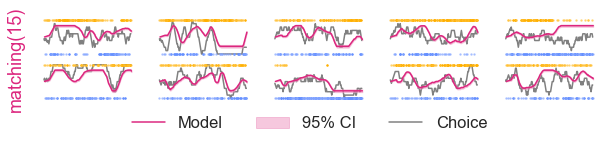

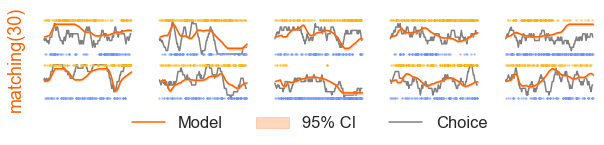

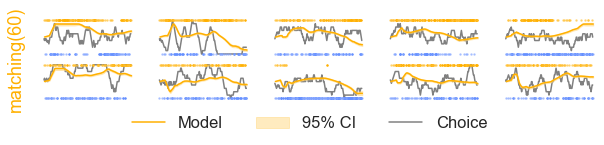

In [70]:
import warnings
warnings.filterwarnings('ignore')
# choose 10 random examples to plot
np.random.seed(13234)
random_examples = np.random.choice(np.arange(test_choice_set.shape[0]), 10, replace=False)

for n,(name,test_prob, test_ci) in enumerate(zip(filtered_names, filtered_test_probs, filtered_test_cis)):
    sns.set(font_scale=1.5,style="white")
    fig,ax = plt.subplots(2,5,figsize=(10,1.5),sharex=True,sharey=True,gridspec_kw={'wspace':0.2,'hspace':0.2})

    for i,data in enumerate(random_examples):
        width = 10
        choice_prob = test_prob[data,:]
        choice_prob_ci = test_ci[:,data,:]

        if i == 0:
            ax.flat[i].plot(np.arange(1,161),choice_prob,label='Model',color=change_lightness(cmap(n/(len(filtered_models)-1)), 1),zorder=1)
            ax.flat[i].fill_between(np.arange(1,161),choice_prob_ci[0,:],choice_prob_ci[1,:],label='95% CI',color=change_lightness(cmap(n/(len(filtered_models)-1)), 0.5),zorder=0,alpha=0.5)
            ax.flat[i].plot(smoothen(test_choice_set[data],width),label='Choice', color='grey',zorder=-1)
        else:
            ax.flat[i].plot(np.arange(1,161),choice_prob,color=change_lightness(cmap(n/(len(filtered_models)-1)), 1),zorder=1)
            ax.flat[i].fill_between(np.arange(1,161),choice_prob_ci[0,:],choice_prob_ci[1,:] ,color=change_lightness(cmap(n/(len(filtered_models)-1)), 0.5),zorder=0,alpha=0.5)
            ax.flat[i].plot(smoothen(test_choice_set[data],width), color='grey',zorder=-1)

        
        ax.flat[i].plot(np.where(np.logical_and(test_choice_set[i] == 0,test_reward_set[i] == 1))[0],
                            np.zeros(np.sum(np.logical_and(test_choice_set[i] == 0,test_reward_set[i] == 1))),'.',color=cmap(0.),markersize=3)
        ax.flat[i].plot(np.where(np.logical_and(test_choice_set[i] == 0,test_reward_set[i] == 0))[0],
                            np.zeros(np.sum(np.logical_and(test_choice_set[i] == 0,test_reward_set[i] == 0))),'.',color=change_lightness(cmap(0.),0.8),alpha=0.5,markersize=3)
        ax.flat[i].plot(np.where(np.logical_and(test_choice_set[i] == 1,test_reward_set[i] == 1))[0],
                            np.ones(np.sum(np.logical_and(test_choice_set[i] == 1,test_reward_set[i] == 1))),'.',color=cmap(1.),markersize=3)
        ax.flat[i].plot(np.where(np.logical_and(test_choice_set[i] == 1,test_reward_set[i] == 0))[0],
                            np.ones(np.sum(np.logical_and(test_choice_set[i] == 1,test_reward_set[i] == 0))),'.',color=change_lightness(cmap(1.),0.8),alpha=0.5,markersize=3)
        for spine in ax.flat[i].spines.values():
            spine.set_visible(False)
        ax.flat[i].set_yticks([])
        # ax.flat[i].set_yticklabels(['MHO','HAL'],fontsize=10)
        ax.flat[i].set_xticks([])
    
    for j in range(i,10):
        for spine in ax.flat[j].spines.values():
            spine.set_visible(False)
        ax.flat[j].set_xticks([])
        ax.flat[j].tick_params(axis='both', which='both', length=0)
    
    # give common x and y labels
    # fig.text(0.5, -0.02, 'Trial', ha='center')
    fig.text(0.08, 0.5, name , va='center', rotation='vertical', color=change_lightness(cmap(n/(len(filtered_models)-1)), 1))
    # add legend
    fig.legend(loc='lower center',ncol=4,frameon=False, bbox_to_anchor=(0.5, -0.3))
    # add title
    plt.tight_layout()
    plt.savefig('figures/{}_model_fit.pdf'.format(name.replace('(','').replace(')','').replace(' ','_')),bbox_inches='tight')
    plt.show()


In [71]:
def formatter(x,y,z):
    return "{:.2f} ({:.2f}–{:.2f})".format(x,y,z)

param = pd.DataFrame([p.describe(percentiles=[0.025,0.975]).drop(['count','std','min','max','50%'],axis=0).T.apply(lambda x: formatter(x['mean'],x['2.5%'],x['97.5%']),axis=1) for p in filtered_params],index=filtered_names).reset_index().rename(columns={'index':'Model'})
param.to_csv('tables/matching_model_parameters.csv',index=False)
param

,Model,intercept,slope,lmax
0,matching(5),0.22 (0.12–0.33),0.92 (0.79–1.04),1.48 (1.26–1.73)
1,matching(10),0.22 (0.12–0.32),0.70 (0.63–0.79),1.90 (1.62–2.20)
2,matching(15),0.22 (0.12–0.31),0.64 (0.57–0.71),2.28 (1.95–2.67)
3,matching(30),0.20 (0.12–0.28),0.55 (0.49–0.62),3.31 (2.75–3.92)
4,matching(60),0.18 (0.10–0.26),0.66 (0.58–0.75),2.92 (2.36–3.53)


In [72]:
# plot model performance for matching models
name_map = {
    'rci': 'R+C+R.C',
    'rc': 'R+C',
    'ci': 'C+R.C',
    'ri': 'R+R.C',
}
filtered_models = [model for model in models if "regression" in model]
filtered_names = ["Best Matching Model"] + ["{} ({})".format(name_map[model.split("/")[-1].split("_")[1]], model.split("/")[-1].split("_")[2]) for model in filtered_models] 
filtered_models = [best_matching_model] + filtered_models
filtered_widths = [10]*len(filtered_models)
# filtered_widths = [best_matching_width] + [int(model.split("/")[-1].split("_")[2]) for model in filtered_models]
filtered_test_nlls = [best_matching_test_nll] + [test_nlls[i] for i in range(len(models)) if "regression" in models[i]]
filtered_training_nlls = [best_matching_training_nll] + [training_nlls[i] for i in range(len(models)) if "regression" in models[i]]
filtered_test_preds = [best_matching_test_preds] + [test_preds[i] for i in range(len(models)) if "regression" in models[i]]
filtered_training_preds = [best_matching_training_preds] + [training_preds[i] for i in range(len(models)) if "regression" in models[i]]

filtered_test_means, filtered_test_se = get_means_and_se(filtered_test_nlls)
filtered_training_means, filtered_training_se = get_means_and_se(filtered_training_nlls)
filtered_test_probs, filtered_test_cis = get_probs_and_ci(filtered_test_preds,filtered_widths)
filtered_training_probs, filtered_training_cis = get_probs_and_ci(filtered_training_preds,filtered_widths)

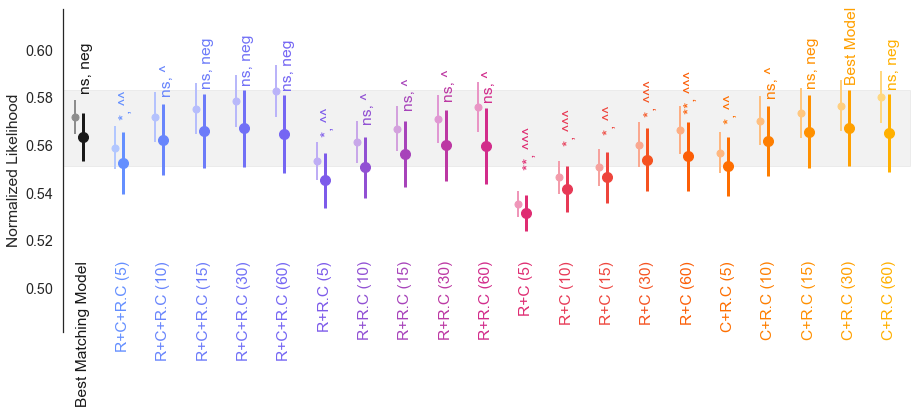

,Model,Test NL,Test NL SE,Training NL,Training NL SE,Test p-value,Test r,Training p-value,Training r
0,Best Matching Model,0.563656,0.010040,0.571999,0.007173,0.567431,0.098990,0.943609,0.008682
1,R+C+R.C (5),0.552760,0.012951,0.559092,0.009020,0.022900,0.393838,0.884214,0.017875
2,R+C+R.C (10),0.562317,0.014920,0.571998,0.010372,0.262820,0.193838,0.950234,0.007661
3,R+C+R.C (15),0.565918,0.015520,0.575423,0.010700,0.962768,0.008081,0.937153,0.009678
4,R+C+R.C (30),0.567199,0.016064,0.578773,0.010836,0.953469,0.010101,0.950234,0.007661
5,R+C+R.C (60),0.564773,0.016458,0.582978,0.010842,0.762011,0.052424,0.946921,0.008172
6,R+R.C (5),0.545453,0.011509,0.553448,0.007931,0.041123,0.353535,0.819150,0.028064
7,R+R.C (10),0.550802,0.012790,0.561417,0.008675,0.112613,0.274646,0.920620,0.012232
8,R+R.C (15),0.556410,0.013812,0.566959,0.009417,0.491481,0.119091,0.937153,0.009678
9,R+R.C (30),0.560125,0.014982,0.571173,0.010032,0.498859,0.117071,0.953548,0.007150


In [73]:
# find statistically significant differences and effect sizes
best_model = 1+np.argmax(filtered_test_means[1:])

pvals = []
rs = []
for i in range(len(filtered_models)):
    pvals_temp = []
    for j in range(filtered_test_nlls[best_model].shape[0]):
        try:
            pvals_temp.append(stats.wilcoxon(filtered_test_nlls[i][j], filtered_test_nlls[best_model][j])[1])
        except:
            pvals_temp.append(np.nan)
    pval = np.quantile(pvals_temp, 0.95)
    pvals.append(pval)
    rs_temp = []
    for j in range(filtered_test_nlls[best_model].shape[0]):
        
        rs_temp.append(pairedRankBiserialCorrelation(filtered_test_nlls[i][j], filtered_test_nlls[best_model][j]))
    r = np.quantile(np.abs(rs_temp), 0.05)
    rs.append(r)

pvals_training = []
rs_training = []
for i in range(len(filtered_models)):
    pvals_temp = []
    for j in range(filtered_training_nlls[best_model].shape[0]):
        try:
            pvals_temp.append(stats.wilcoxon(filtered_training_nlls[i][j], filtered_training_nlls[best_model][j])[1])
        except:
            pvals_temp.append(np.nan)
    pval = np.quantile(pvals_temp, 0.95)
    pvals_training.append(pval)
    rs_temp = []
    for j in range(filtered_training_nlls[best_model].shape[0]):
        
        rs_temp.append(pairedRankBiserialCorrelation(filtered_training_nlls[i][j], filtered_training_nlls[best_model][j]))
    r = np.quantile(np.abs(rs_temp), 0.05)
    rs_training.append(r)

sns.set(font_scale=1.3,style="white")
fig, ax = plt.subplots(figsize=(13,6))
for i in range(len(filtered_models)):
    if i == 0:
        color='k'
    else:
        color=cmap((i-1)/(len(filtered_models)-2))
    ax.errorbar(i, filtered_test_means[i], yerr=filtered_test_se[i], color=change_lightness(color, 1), elinewidth=3, markersize=10, fmt= 'o')
    ax.errorbar(i-0.2, filtered_training_means[i], yerr=filtered_training_se[i], color=change_lightness(color, 0.5), elinewidth=2, markersize=7, fmt= 'o')
    ax.text(i, min(filtered_test_means)-0.02, filtered_names[i], ha='center', va='top', rotation=90, color=change_lightness(color, 1))
    # add significance
    if i != best_model:
        ax.text(i+0.08, np.max(filtered_test_means[i])+0.018, f"{pvalue_to_stars(pvals[i])}, {r_to_effect(rs[i])}", ha='center', va='bottom', rotation=90, color=change_lightness(color, 1))
    else:
        ax.text(i+0.08, np.max(filtered_test_means[i])+0.018, f"Best Model", ha='center', va='bottom', rotation=90, color=change_lightness(color, 1))
# draw reference region
ax.fill_between([-0.5, len(filtered_models)-0.5], filtered_test_means[best_model]-filtered_test_se[best_model], filtered_test_means[best_model]+filtered_test_se[best_model], color='gray', alpha=0.1)
ax.set_xticks([])
ax.set_ylabel("Normalized Likelihood")
ax.set_ylim([min(filtered_test_means)-0.05, max(filtered_test_means)+0.05])
ax.set_xlim([-0.5, len(filtered_models)-0.5])
# turn off all spines except left
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig("figures/Regression_summary.pdf", bbox_inches='tight')
plt.show()

statistics = pd.DataFrame({
    "Model": filtered_names,
    "Test NL": filtered_test_means,
    "Test NL SE": filtered_test_se,
    "Training NL": filtered_training_means,
    "Training NL SE": filtered_training_se,
    "Test p-value": pvals,
    "Test r": rs,
    "Training p-value": pvals_training,
    "Training r": rs_training
})
statistics.to_csv("tables/Regression_summary.csv", index=False)
statistics


In [58]:
# filter models to only 30 width
filtered_models = [model for model in models if "regression" in model and "30" in model]
filtered_names = ["{} ({})".format(name_map[model.split("/")[-1].split("_")[1]], model.split("/")[-1].split("_")[2]) for model in filtered_models]
filtered_widths = [10]*len(filtered_models)
#[int(model.split("/")[-1].split("_")[2]) for model in filtered_models]
filtered_test_nlls = [test_nlls[i] for i in range(len(models)) if "regression" in models[i] and "30" in models[i]]
filtered_training_nlls = [training_nlls[i] for i in range(len(models)) if "regression" in models[i] and "30" in models[i]]
filtered_test_preds = [test_preds[i] for i in range(len(models)) if "regression" in models[i] and "30" in models[i]]
filtered_training_preds = [training_preds[i] for i in range(len(models)) if "regression" in models[i] and "30" in models[i]]

filtered_test_means, filtered_test_se = get_means_and_se(filtered_test_nlls)
filtered_training_means, filtered_training_se = get_means_and_se(filtered_training_nlls)
filtered_test_probs, filtered_test_cis = get_probs_and_ci(filtered_test_preds,filtered_widths)
filtered_training_probs, filtered_training_cis = get_probs_and_ci(filtered_training_preds,filtered_widths)

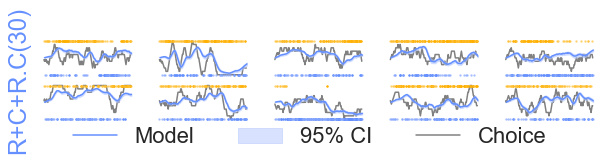

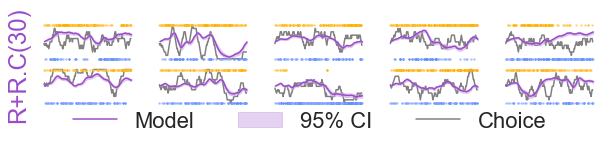

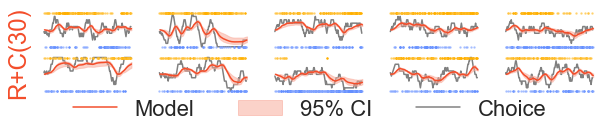

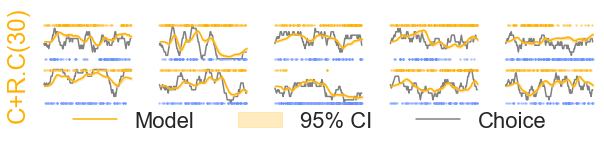

In [59]:
import warnings
warnings.filterwarnings('ignore')
# choose 10 random examples to plot
np.random.seed(13234)
random_examples = np.random.choice(np.arange(test_choice_set.shape[0]), 10, replace=False)

for n,(name,test_prob, test_ci) in enumerate(zip(filtered_names, filtered_test_probs, filtered_test_cis)):
    sns.set(font_scale=2,style="white")
    fig,ax = plt.subplots(2,5,figsize=(10,1.5),sharex=True,sharey=True,gridspec_kw={'wspace':0.2,'hspace':0.2})

    for i,data in enumerate(random_examples):
        width = 10
        choice_prob = test_prob[data,:]
        choice_prob_ci = test_ci[:,data,:]
        if i == 0:
            ax.flat[i].plot(np.arange(1,161),choice_prob,label='Model',color=change_lightness(cmap(n/(len(filtered_models)-1)), 1),zorder=1)
            ax.flat[i].fill_between(np.arange(1,161),choice_prob_ci[0,:],choice_prob_ci[1,:],label='95% CI',color=change_lightness(cmap(n/(len(filtered_models)-1)), 0.5),zorder=0,alpha=0.5)
            ax.flat[i].plot(smoothen(test_choice_set[data],width),label='Choice', color='grey',zorder=-1)
        else:
            ax.flat[i].plot(np.arange(1,161),choice_prob,color=change_lightness(cmap(n/(len(filtered_models)-1)), 1),zorder=1)
            ax.flat[i].fill_between(np.arange(1,161),choice_prob_ci[0,:],choice_prob_ci[1,:] ,color=change_lightness(cmap(n/(len(filtered_models)-1)), 0.5),zorder=0,alpha=0.5)
            ax.flat[i].plot(smoothen(test_choice_set[data],width), color='grey',zorder=-1)

        
        ax.flat[i].plot(np.where(np.logical_and(test_choice_set[i] == 0,test_reward_set[i] == 1))[0],
                            np.zeros(np.sum(np.logical_and(test_choice_set[i] == 0,test_reward_set[i] == 1))),'.',color=cmap(0.),markersize=3)
        ax.flat[i].plot(np.where(np.logical_and(test_choice_set[i] == 0,test_reward_set[i] == 0))[0],
                            np.zeros(np.sum(np.logical_and(test_choice_set[i] == 0,test_reward_set[i] == 0))),'.',color=change_lightness(cmap(0.),0.8),alpha=0.5,markersize=3)
        ax.flat[i].plot(np.where(np.logical_and(test_choice_set[i] == 1,test_reward_set[i] == 1))[0],
                            np.ones(np.sum(np.logical_and(test_choice_set[i] == 1,test_reward_set[i] == 1))),'.',color=cmap(1.),markersize=3)
        ax.flat[i].plot(np.where(np.logical_and(test_choice_set[i] == 1,test_reward_set[i] == 0))[0],
                            np.ones(np.sum(np.logical_and(test_choice_set[i] == 1,test_reward_set[i] == 0))),'.',color=change_lightness(cmap(1.),0.8),alpha=0.5,markersize=3)
        for spine in ax.flat[i].spines.values():
            spine.set_visible(False)
        ax.flat[i].set_yticks([])
        # ax.flat[i].set_yticklabels(['MHO','HAL'],fontsize=10)
        ax.flat[i].set_xticks([])
    
    for j in range(i,10):
        for spine in ax.flat[j].spines.values():
            spine.set_visible(False)
        ax.flat[j].set_xticks([])
        ax.flat[j].tick_params(axis='both', which='both', length=0)
    
    # give common x and y labels
    # fig.text(0.5, -0.02, 'Trial', ha='center')
    fig.text(0.08, 0.5, name.replace(' ','') , va='center', rotation='vertical', color=change_lightness(cmap(n/(len(filtered_models)-1)), 1))
    # add legend
    fig.legend(loc='lower center',ncol=4,frameon=False, bbox_to_anchor=(0.5, -0.3))
    # add title
    plt.tight_layout()
    plt.savefig('figures/{}_model_fit.pdf'.format(name.replace('(','').replace(')','').replace(' ','_')),bbox_inches='tight')
    plt.show()


In [60]:
filtered_params = [params[i] for i in range(len(models)) if "regression" in models[i] and "30" in models[i]]
filtered_names = ["{} ({})".format(name_map[model.split("/")[-1].split("_")[1]], model.split("/")[-1].split("_")[2]) for model in filtered_models]

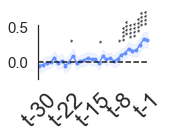

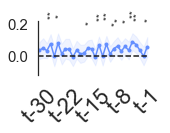

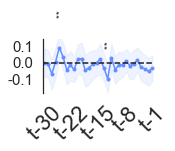

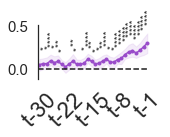

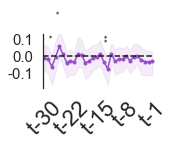

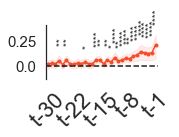

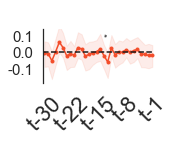

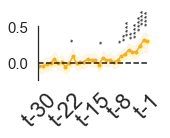

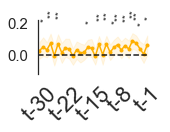

In [66]:
def pvalue_to_stars_(pvalue):
    if pvalue < 0.0001:
        return '****'
    elif pvalue < 0.001:
        return '***'
    elif pvalue < 0.01:
        return '**'
    elif pvalue < 0.05:
        return '*'
    else:
        return ''

def d_to_effect_(d):
    return ''

def formatter(x,y,z):
    return "{:.3f} ({:.3f}–{:.3f})".format(x,y,z)

def clean_df(table):
    table = table.copy()
    table['value'] = table.apply(lambda x: formatter(x['mean'],x['2.5%'],x['97.5%']),axis=1)
    table['p'] = table.apply(lambda x: f"{x.values[0]:0.3f} ("+pvalue_to_stars(x['pval'])+")",axis=1)
    table['d'] = table.apply(lambda x: f"{x.values[0]:0.3f} ("+d_to_effect(x['eff'])+")",axis=1)
    table['time'] = table.apply(lambda x: f"t-{x['var'].split('_')[-1]}",axis=1)
    return table[['time','value','p','d']]
    
for n,(p,names) in enumerate(zip(filtered_params,filtered_names)):
    color = change_lightness(cmap(n/(len(filtered_models)-1)), 1)
    i_true = False
    c_true = False
    r_true = False
    # find interaction terms (if any)
    columns = [i for i in p.columns if 'w_choice_reward' in i]
    if len(columns)>0:
        i_true = True
        # sort by interaction term
        columns = sorted(columns, key=lambda x: int(x.split('_')[-1]), reverse=True)
        interactions = p.loc[:,columns].values
        # find mean, 95% CI, p-value and effect size
        mean = np.mean(interactions,axis=0)
        ci = np.percentile(interactions,[2.5,97.5],axis=0)
        pval = np.mean(interactions<0,axis=0)
        effect_size = mean/np.std(interactions,axis=0)
        df_interactions = pd.DataFrame({'mean':mean,'2.5%':ci[0,:],'97.5%':ci[1,:],'pval':pval,'eff':effect_size,'var':columns})
        df_interactions = clean_df(df_interactions)
        # df_interactions.to_csv('tables/{}_interaction_terms.csv'.format(names.replace('(','').replace(')','').replace(' ','_')))
        # plot
        sns.set(style="white",font_scale=2)
        fig,ax = plt.subplots(1,1,figsize=(2,1))
        ax.plot(np.arange(len(columns)),mean,'o-',color=color,markersize=3)
        ax.fill_between(np.arange(len(columns)),ci[0,:],ci[1,:],color=color,alpha=0.1)
        for i in range(len(columns)):
            ax.text(i+0.6,ci[1,i]+0.1,'{} {}'.format(pvalue_to_stars_(pval[i]),d_to_effect_(effect_size[i])),ha='center',va='bottom', rotation=90,fontsize=10)
        ax.set_xticks(np.linspace(0,len(columns)-1,5))
        ax.set_xticklabels(['t-{}'.format(i) for i in np.linspace(1,len(columns),5,dtype=int)[::-1]],rotation=45)
        # ax.set_ylabel('Interaction')
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.set_xlim([-0.5,len(columns)-0.5])
        ax.axhline(0,color='k',linestyle='--')
        # ax.set_ylim([-0.2,1.0])
        ax.set_ylim([ci[0,0]-0.1,ci[1,-1]+0.1])
        ax.set_yticklabels(np.round(ax.get_yticks(),2),fontsize=15)
        plt.tight_layout()
        plt.savefig('figures/{}_interaction.pdf'.format(names.replace('(','').replace(')','').replace(' ','_')),bbox_inches='tight')
        plt.show()

    # find choice terms (if any)
    columns = [i for i in p.columns if 'w_choice' in i and 'w_choice_reward' not in i]
    if len(columns)>0:
        c_true = True
        # sort by choice term
        columns = sorted(columns, key=lambda x: int(x.split('_')[-1]), reverse=True)
        choices = p.loc[:,columns].values
        # find mean, 95% CI, p-value and effect size
        mean = np.mean(choices,axis=0)
        ci = np.percentile(choices,[2.5,97.5],axis=0)
        pval = np.mean(choices<0,axis=0)
        effect_size = mean/np.std(choices,axis=0)
        df_choices = pd.DataFrame({'mean':mean,'2.5%':ci[0,:],'97.5%':ci[1,:],'pval':pval,'eff':effect_size,'var':columns})
        df_choices = clean_df(df_choices)
        # df_choices.to_csv('tables/{}_choice_terms.csv'.format(names.replace('(','').replace(')','').replace(' ','_')))
        # plot
        sns.set(style="white",font_scale=2)
        fig,ax = plt.subplots(1,1,figsize=(2,1))
        ax.plot(np.arange(len(columns)),mean,'o-',color=color,markersize=3)
        ax.fill_between(np.arange(len(columns)),ci[0,:],ci[1,:],color=color,alpha=0.1)
        for i in range(len(columns)):
            ax.text(i+0.6,ci[1,i]+0.1,'{} {}'.format(pvalue_to_stars_(pval[i]),d_to_effect_(effect_size[i])),ha='center',va='bottom', rotation=90,fontsize=10)
        ax.set_xticks(np.linspace(0,len(columns)-1,5))
        ax.set_xticklabels(['t-{}'.format(i) for i in np.linspace(1,len(columns),5,dtype=int)[::-1]],rotation=45)
        # ax.set_ylabel('Choice')
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.set_xlim([-0.5,len(columns)-0.5])
        ax.axhline(0,color='k',linestyle='--')
        # ax.set_ylim([-0.5,0.5])
        ax.set_ylim([ci[0,0]-0.1,ci[1,-1]+0.1])
        ax.set_yticklabels(np.round(ax.get_yticks(),2),fontsize=15)
        plt.tight_layout()
        plt.savefig('figures/{}_choice.pdf'.format(names.replace('(','').replace(')','').replace(' ','_')),bbox_inches='tight')
        plt.show()

    # find reward terms (if any)
    columns = [i for i in p.columns if 'w_reward' in i]
    if len(columns)>0:
        r_true = True
        # sort by reward term
        columns = sorted(columns, key=lambda x: int(x.split('_')[-1]), reverse=True)
        rewards = p.loc[:,columns].values
        # find mean, 95% CI, p-value and effect size
        mean = np.mean(rewards,axis=0)
        ci = np.percentile(rewards,[2.5,97.5],axis=0)
        # two-tailed p-value
        pval = np.min([np.mean(rewards<0,axis=0),np.mean(rewards>0,axis=0)],axis=0)
        effect_size = mean/np.std(rewards,axis=0)
        df_rewards = pd.DataFrame({'mean':mean,'2.5%':ci[0,:],'97.5%':ci[1,:],'pval':pval,'eff':effect_size,'var':columns})
        df_rewards = clean_df(df_rewards)
        # df_rewards.to_csv('tables/{}_reward_terms.csv'.format(names.replace('(','').replace(')','').replace(' ','_')))
        # plot
        sns.set(style="white",font_scale=2)
        fig,ax = plt.subplots(1,1,figsize=(2,1))
        ax.plot(np.arange(len(columns)),mean,'o-',color=color,markersize=3)
        ax.fill_between(np.arange(len(columns)),ci[0,:],ci[1,:],color=color,alpha=0.1)
        for i in range(len(columns)):
            ax.text(i+0.6,ci[1,i]+0.1,'{} {}'.format(pvalue_to_stars_(pval[i]),d_to_effect_(effect_size[i])),ha='center',va='bottom', rotation=90,fontsize=10)
        ax.set_xticks(np.linspace(0,len(columns)-1,5))
        ax.set_xticklabels(['t-{}'.format(i) for i in np.linspace(1,len(columns),5,dtype=int)[::-1]],rotation=45)
        # ax.set_ylabel('Reward')
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.set_xlim([-0.5,len(columns)-0.5])
        ax.axhline(0,color='k',linestyle='--')
        # ax.set_ylim([-0.5,0.5])
        # set yticks to be with font size 10
        ax.set_ylim([ci[0,0]-0.1,ci[1,-1]+0.1])
        ax.set_yticklabels(np.round(ax.get_yticks(),2),fontsize=15)
        plt.tight_layout()
        plt.savefig('figures/{}_reward.pdf'.format(names.replace('(','').replace(')','').replace(' ','_')),bbox_inches='tight')
        plt.show()

    if c_true:
        df_choices.columns = ['Lag','Mean(95% CI) [C]','P-value [C]','d [C]']
    if r_true:
        df_rewards.columns = ['Lag','Mean(95% CI) [R]','P-value [R]','d [R]']
    if i_true:
        df_interactions.columns = ['Lag','Mean(95% CI) [R.C]','P-value [R.C]','d [R.C]']
    if c_true and r_true and i_true:
        df = pd.concat([df_choices,df_rewards,df_interactions],axis=1)
    elif c_true and r_true:
        df = pd.concat([df_choices,df_rewards],axis=1)
    elif c_true and i_true:
        df = pd.concat([df_choices,df_interactions],axis=1)
    elif r_true and i_true:
        df = pd.concat([df_rewards,df_interactions],axis=1)

    df.to_csv('tables/{}_kernels.csv'.format(names.replace('(','').replace(')','').replace(' ','_')))